In [30]:
#T-SNE implementation using bag of words-uni-gram bi-gram,tf-idf-word-vec,avg Word-vec,tf-idf
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [55]:
con=sqlite3.connect('database.sqlite')

In [56]:
new_data = pd.read_sql_query(""" Select *  from Reviews  where Score!=3""", con)


In [57]:
new_data=new_data[:2000]
new_data.head()
new_data.shape

(2000, 10)

In [58]:
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and vice-versa
actualScore = new_data['Score']
positiveNegative = actualScore.map(partition) 
new_data['Score'] = positiveNegative
print("Number of data points in our data", new_data.shape)
new_data.head(3)

Number of data points in our data (2000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [59]:
sorted_data=new_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(1998, 10)

In [60]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [61]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')

{'each', 'too', "couldn't", 'mightn', 'yours', 'have', 'hadn', 'here', 'his', "aren't", 'which', "don't", 'did', 'shan', 'isn', "mightn't", "should've", 'these', "you're", 'hers', 'aren', "doesn't", 'were', 'she', 'their', 'doing', 'couldn', 'such', 'now', "haven't", 'so', 'both', "you'd", 'i', 'there', "shouldn't", "wouldn't", "won't", 'had', 'and', 'who', 'any', 'd', 'up', 'with', 'until', 'before', 'other', 'very', 'while', "isn't", 'what', 'of', 'be', 'under', 'they', 'does', 'your', 'as', 'being', 'once', 'nor', 'won', 'don', 'in', 'yourself', 'only', 'out', 'if', 'herself', 'theirs', 'myself', 'themselves', "hadn't", 'me', 'or', "wasn't", 'same', 'has', 'is', 'just', 'haven', 'hasn', 'doesn', 'down', 'itself', 'above', 'that', 'not', 'during', 'against', 'are', 'our', 'ain', 'am', "needn't", 'between', 'more', "hasn't", 'wasn', 'this', 'for', 's', 'where', 'from', 'was', 'again', 'into', 'whom', 'wouldn', 'after', 'it', 'ours', 'll', 'shouldn', 'on', 'her', 'an', 'few', 'we', 'it

In [62]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == '1': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == '0':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:05<00:00, 350.48it/s]


In [63]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    
    conn.close()
else:
    print("Please the above cell")
    #Connnecting to the final.sqlite database
  

In [64]:
print(final['CleanedText'].head())  
#CHecking the cleaned text 

0    receiv shipment could hard wait tri product lo...
1    realli good idea final product outstand use de...
2    nine cat crazi kibbl last thing want cat food ...
3    product allow make realli big splash provid sp...
4    purchas item cake call gold dust never thought...
Name: CleanedText, dtype: object


In [ ]:
#save file as new final data for clean text


In [65]:
# implementation of BAG-Of-WORDS  using countvectorizer

count_vect = CountVectorizer( ) #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1998, 5470)
the number of unique words  5470


In [66]:
   #taking the first 1k points of sparse matrix
   print(final_counts.shape) 
   FIRST_1K_POINTS=final_counts[:1000]
   print(FIRST_1K_POINTS.shape) 
    

(1998, 5470)
(1000, 5470)


In [67]:
#Here data standardization is done and the new data matrix formed is sparse matrix
#So sparse matrix is also converted to dense by using to dense method    
from sklearn.preprocessing import StandardScaler
standarized_new_data=StandardScaler( with_mean=False).fit_transform(FIRST_1K_POINTS)
print(standarized_new_data.shape)
z=standarized_new_data.todense()
print(z.shape)
review_score=new_data['Score'][:1000]
print(review_score.shape)
#taking the first 1000 values of score column

(1000, 5470)
(1000, 5470)
(1000,)


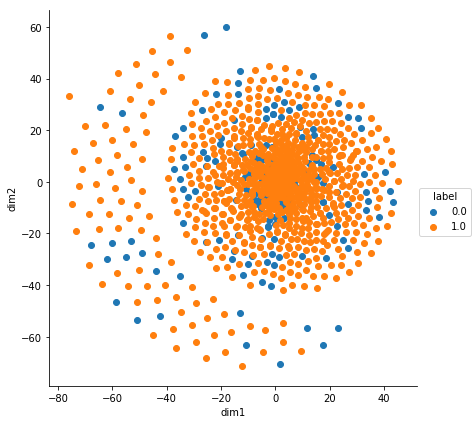

In [68]:
#BUILDING T-SNE MODEL AND FITTING THE DATA
from sklearn.manifold import TSNE
import seaborn as sns
model=TSNE(random_state=0,n_iter=400,n_components=2,perplexity=20)
tsne_data=model.fit_transform(z)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#this visualization is done with the help of n_iter=400 and perplexity=20
#In the next line i will be checking different plots with differnet values of parameters of n_iter
# and perplexity


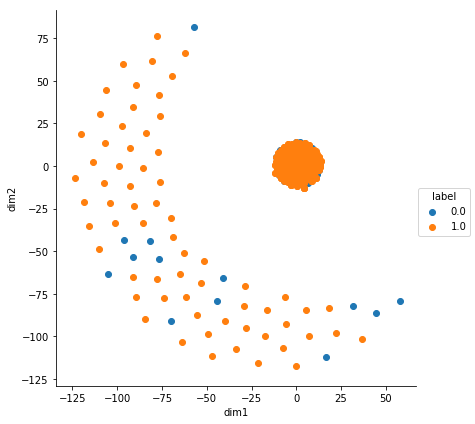

In [69]:
from sklearn.manifold import TSNE
import seaborn as sns
model=TSNE(random_state=0,n_iter=4000,n_components=2,perplexity=40)
tsne_data=model.fit_transform(z)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#this visualization is done with the help of n_iter=4000 and perplexity=40

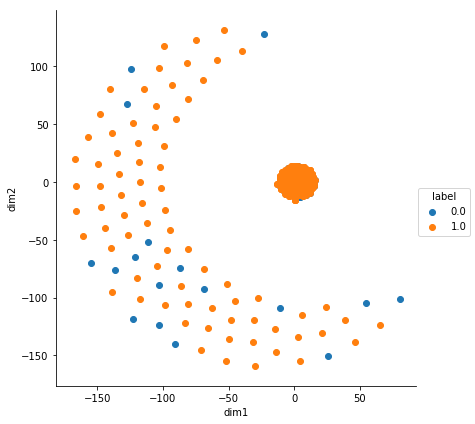

In [70]:
from sklearn.manifold import TSNE
import seaborn as sns
model=TSNE(random_state=0,n_iter=3000,n_components=2,perplexity=30)
tsne_data=model.fit_transform(z)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#this visualization is done with the help of n_iter=3000 and perplexity=30

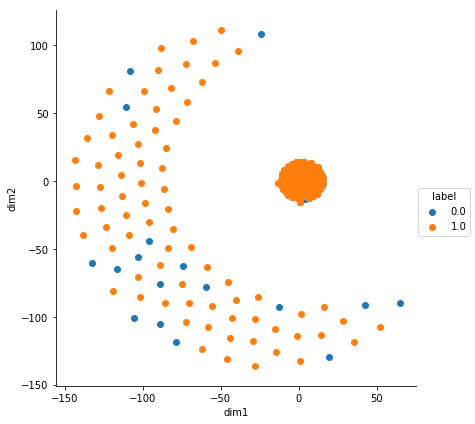

In [71]:
from sklearn.manifold import TSNE
import seaborn as sns
model=TSNE(random_state=0,n_iter=2000,n_components=2,perplexity=30)
tsne_data=model.fit_transform(z)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#this visualization is done with the help of n_iter=2000 and perplexity=30

In [37]:
#from the above observations it is found that most of positive reviews have values of 10 to -10 for both 
# dimension dim1 and dim2.this is the visualization for first 1000 points. 

In [85]:
#bi-gram,uni-gram 
count_vect = CountVectorizer(ngram_range=(1,2)) #here all uni-gram and bi-gram are generated
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)#data is fiited into modefinal_bigram_counts.todense()
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1998, 55953)
the number of unique words including both unigrams and bigrams  55953


In [90]:
#taking first 1000 points only
final_bigram_counts=final_bigram_counts[:1000]
from sklearn.decomposition import TruncatedSVD
svd =TruncatedSVD(n_components=2000, n_iter=7, random_state=4)
svd.fit(final_bigram_counts)




matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [94]:
final_bigram=final_bigram_counts.toarray()


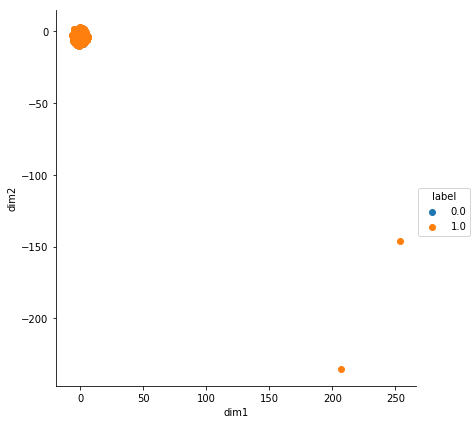

In [97]:
#Now visualization using t-sne
#BUILDING T-SNE MODEL AND FITTING THE DATA
from sklearn.manifold import TSNE
import seaborn as sns
model1=TSNE(random_state=0,n_iter=4000,n_components=2,perplexity=40)
tsne_data=model1.fit_transform(final_bigram)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#this visualization is done with the help of n_iter=4000 and perplexity=20
#VISUALIZATION WITH T-SNE IS DONE FOR BI-GRAM AND UNI-GRAM
#FROM THE BELOW PLOT IT IS FOUND THAT MOST OF THE POINTS WHICH ARE HAVING REVIEW>3 ARE HAVING 
#DIMENSIONS DIM1  & DIM2  VALUE AS DIM1= 0 TO 10 AND DIM2= -15 TO 5.

###################################################################

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1998, 55953)
the number of unique words including both unigrams and bigrams  55953


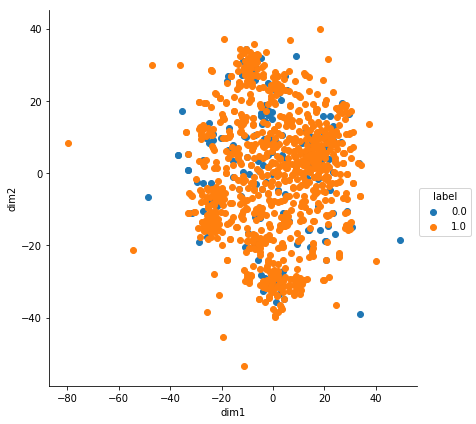

In [96]:
#### VISUALIZING  AND VERTORIZATION  T-SNE WITH TF-IDF##############################################
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
final_tf_idf=final_tf_idf[:1000]
from sklearn.decomposition import TruncatedSVD
svd =TruncatedSVD(n_components=2000, n_iter=7, random_state=4)
svd.fit(final_tf_idf)
fully_final_tf_idf=final_tf_idf.toarray()
#BUILDING TSNE MODEL AND FIITING THE DATA 
from sklearn.manifold import TSNE
import seaborn as sns
model=TSNE(random_state=0,n_iter=1000,n_components=2,perplexity=40)
tsne_data=model.fit_transform(fully_final_tf_idf)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()

#VERTORIZATION AND VISUALIZATION FOR  OF TF-IDF USING T-SNE IS DONE
###################################################################################################

In [102]:
# Training my own Word2Vec model using your own text corpus
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())#splitting of sentences into words AND appending them to list
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])
word_to_vector=Word2Vec(list_of_sent,min_count=5,size=50,workers=2)#constructing my our word to vector
w_t_c_words=list(word_to_vector.wv.vocab)
print("***********************************************************************")
print("sample words ", w_t_c_words[0:50])

receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor
*****************************************************************
['receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'product', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'revers', 'use', 'car', 'window', 'print', 'beauti', 'print', 'shop', 'program', 'go', 'lot', 'fun', 'product', 'window', 'everywher', 'surfac', 'like', 'screen', 'comput', 'monitor']
***********************************************************************
sample words  ['receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'product', 'love', 'call', 'instead', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'use', 'car', 'beauti', 'shop', 'go', 'lot', 'fun', 'everywher', 'like', 'realli', 'good', 'idea', 'final', 'outstand

In [108]:
word_to_vector.wv.most_similar('amazon')# checking similarity of word amazon

[('price', 0.9996016621589661),
 ('product', 0.9995806217193604),
 ('purchas', 0.9995207786560059),
 ('ship', 0.9995095729827881),
 ('bought', 0.9994964599609375),
 ('item', 0.9994838237762451),
 ('month', 0.9994266629219055),
 ('find', 0.9994165897369385),
 ('expens', 0.9994004964828491),
 ('onlin', 0.9993935823440552)]

In [110]:
###### NOW STARTING AVERAGE WORD TO VEC#################################################################
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w_t_c_words:
            vec = word_to_vector.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:02<00:00, 773.62it/s]


1998
50


In [121]:
sent_vectors=np.array(sent_vectors[:1000])
print(sent_vectors.shape)
print(review_score.shape)


(1000, 50)
(1000,)


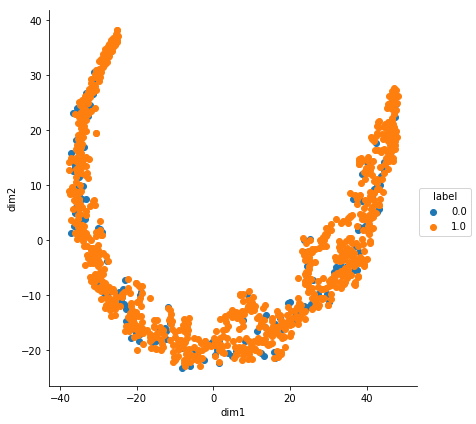

In [122]:
from sklearn.manifold import TSNE
import seaborn as sns
model1=TSNE(random_state=0,n_iter=4000,n_components=2,perplexity=40)
tsne_data=model1.fit_transform(sent_vectors)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#THIS IS THE VISUALIZATION FOR FIRST 1000 POINTS FOR AVG WORD TO VEC BY TAKING N_COMPONENTS=2
# AND PERPLEXITY =40 AND ITERATIONS=4000

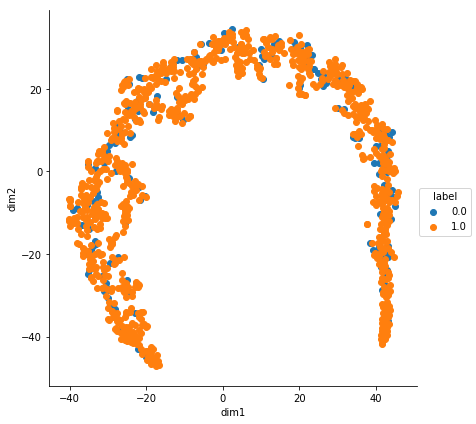

In [123]:
from sklearn.manifold import TSNE
import seaborn as sns
model1=TSNE(random_state=0,n_iter=3000,n_components=2,perplexity=30)
tsne_data=model1.fit_transform(sent_vectors)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#THIS IS THE VISUALIZATION FOR FIRST 1000 POINTS FOR AVG WORD TO VEC BY TAKING N_COMPONENTS=2
# AND PERPLEXITY =30 AND ITERATIONS=4000

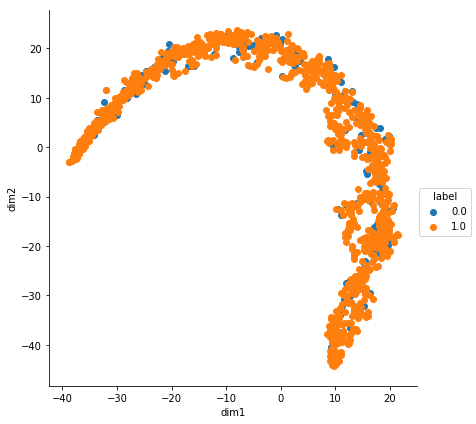

In [124]:
from sklearn.manifold import TSNE
import seaborn as sns
model1=TSNE(random_state=0,n_iter=2000,n_components=2,perplexity=50)
tsne_data=model1.fit_transform(sent_vectors)
tsne_data=np.vstack((tsne_data.T,review_score)).T
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#THIS IS THE VISUALIZATION FOR FIRST 1000 POINTS FOR AVG WORD TO VEC BY TAKING N_COMPONENTS=2
# AND PERPLEXITY =50 AND ITERATIONS=4000

In [129]:
#NOW STARTING TF-IDF WEIGHTED WORD-TO-VEC
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w_t_c_words:
            vec = word_to_vector.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:02<00:00, 701.74it/s]


In [131]:
#NOW CONVERTING TF-IDF VECTORS INTO 2-D MATRIX
tfidf_sent_vectors=np.array(tfidf_sent_vectors[:1000])#ONLY 1000 POINTS
tfidf_sent_vectors.shape

(1000, 50)

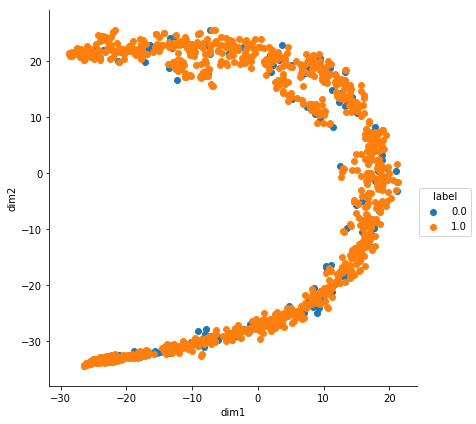

In [132]:
#NOW VISUALISING THE DATA AND PLOTING AFTER BUILDING T-SNE MODEL
from sklearn.manifold import TSNE
import seaborn as sns
model1=TSNE(random_state=0,n_iter=2000,n_components=2,perplexity=50)
tsne_data=model1.fit_transform(tfidf_sent_vectors)
tsne_data=np.vstack((tsne_data.T,review_score)).T
#BUILDING A NEW MODEL BY TAKING VECTORS AND 
#TARGET VAARIABLE AS SCORE OF REVIEWS DATASET
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#THIS IS THE VISUALIZATION FOR FIRST 1000 POINTS FOR AVG TF-IDF VECTORS BY TAKING N_COMPONENTS=2
# AND PERPLEXITY =50 AND ITERATIONS=4000


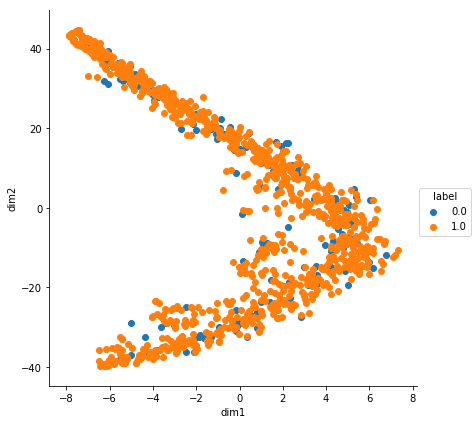

In [133]:
from sklearn.manifold import TSNE
import seaborn as sns
model1=TSNE(random_state=0,n_iter=4000,n_components=2,perplexity=70)
tsne_data=model1.fit_transform(tfidf_sent_vectors)
tsne_data=np.vstack((tsne_data.T,review_score)).T
#BUILDING A NEW MODEL BY TAKING VECTORS AND 
#TARGET VAARIABLE AS SCORE OF REVIEWS DATASET
t_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','label'))
#New dataframe is created with cloumn name as dim1,dim2,label where label contains
#value of 1 and 0 only.
sns.FacetGrid(t_df, hue="label", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()
#THIS IS THE VISUALIZATION FOR FIRST 1000 POINTS FOR AVG TF-IDF VECTORS BY TAKING N_COMPONENTS=2
# AND PERPLEXITY =70 AND ITERATIONS=4000

In [134]:
#THESE ARE VISUALIZATION BY TAKING FIRST 1000 DATA POINTS ONLY.IF ALL DATA POINTS WERE TAKEN WE COULD 
#EASILY DISTINGUISH BETWEEN +VE AND -VE REVIEWS WITH THE HELP OF VARIOUS TECHNIQUES AS 
#DISCUSSED IN THE CHAPTER 

In [135]:
###########################---END OF ASSIGNMENT----####################################################

In [ ]:
########################### THANK YOU APPLIEDAICOURSE FOR THESE CHALLENGING ASSIGNMENTS###############